In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%watermark --iversions

pandas  0.22.0
pyfolio 0.9.2
numpy   1.11.3
zipline v1.3.0
pytz    2016.6.1



# 3. Strategy with fix rebalance period and deferred purchase

## Формируем данные для анализа стратегии

In [35]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['PriceUSD', 'CapMrktCurUSD', 'NVTAdj90', 'NVTAdj']

In [36]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].tail())

               PriceUSD  CapMrktCurUSD   NVTAdj90      NVTAdj
date                                                         
2020-01-09  7817.136093   1.418914e+11  81.490397   66.196558
2020-01-10  8129.817920   1.475821e+11  84.211381   72.562711
2020-01-11  8032.005495   1.458229e+11  83.096938  134.438760
2020-01-12  8164.549993   1.482447e+11  85.782071  162.633673
2020-01-13  8121.925668   1.474853e+11  85.388178   89.003794
              PriceUSD  CapMrktCurUSD   NVTAdj90      NVTAdj
date                                                        
2020-01-09  137.473664   1.501373e+10  65.621005   86.322973
2020-01-10  143.789401   1.570545e+10  68.768279   90.401457
2020-01-11  142.846074   1.560437e+10  68.230567   93.064330
2020-01-12  145.447126   1.589049e+10  70.331746  123.466616
2020-01-13  143.910222   1.572454e+10  69.737285   86.656545


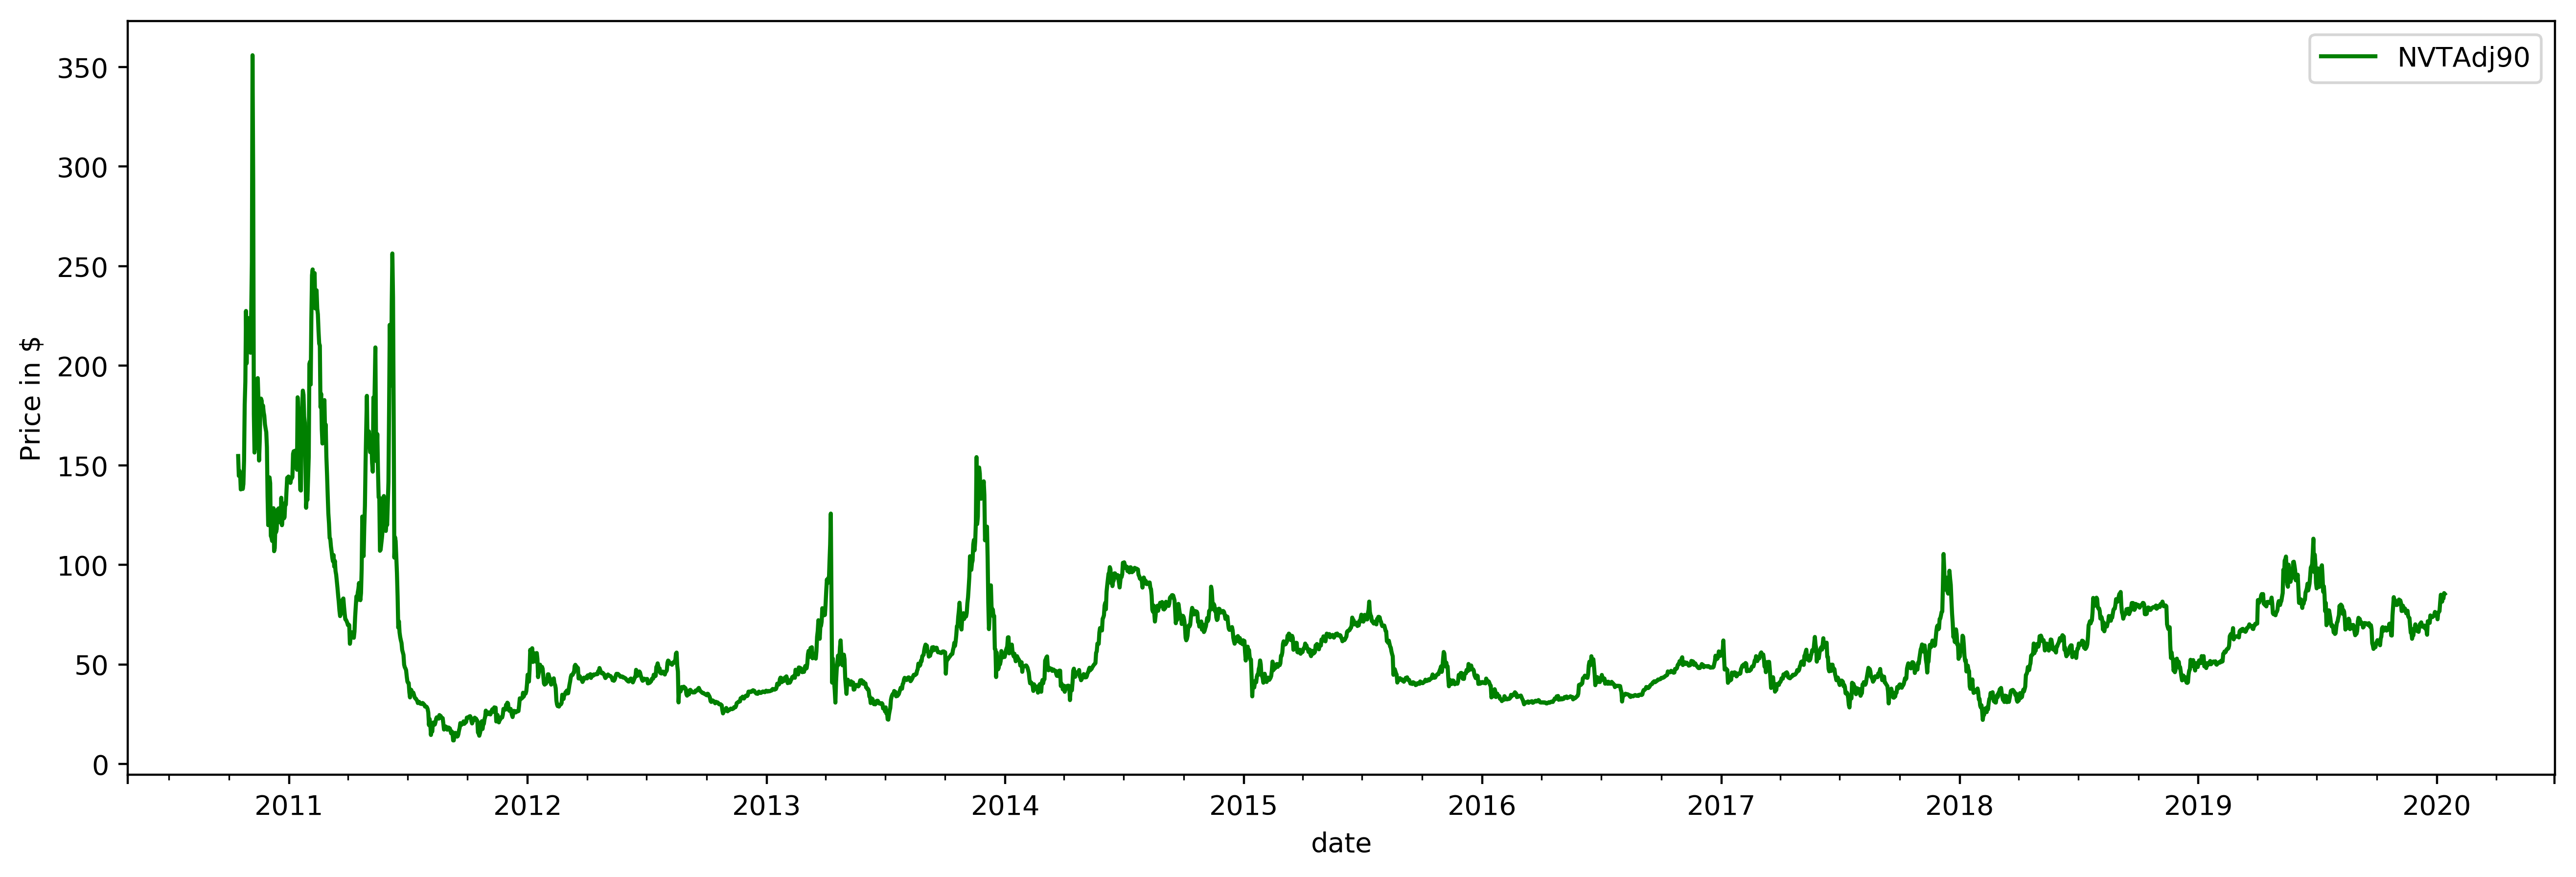

In [39]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
data['BTC']['NVTAdj90'].plot(color='g')
ax.set_ylabel('Price in $')
#ax.tick_params(axais = 'x', direction = 'out')

plt.legend()
#plt.yscale('log')
plt.show()

## Приводим данные к одинаковой длинне

In [7]:
for tiker in TIKERS:
    if tiker == 'BTC':
        continue
    else:
        tmp = data['BTC'].copy()
        for column in COLUMNS:
            tmp[column] = 0    

        # удаляем лишнее
        tmp = tmp.iloc[:(len(tmp)-len(data[tiker]))]

        # Вносим данные
        tmp = tmp.append(data[tiker], ignore_index = False)
        data[tiker] = tmp

In [12]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

ValueError: cannot reindex from a duplicate axis

## Определяем функции алгоритма

In [53]:
WEIGHTS = [[0.8, 0, 0], [0.55, 0.25, 0], [0.5, 0.2, 0.1]]
ASSETS_START = [date(2017, 1, 2), date(2017, 11, 1)]
COMMISSION = 0.0007

In [54]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.stage = 0
    
    context.assets_start = ASSETS_START
    
    context.rebalance_period = 30
    context.time = 0

In [55]:
def asset_chek(context, day, n):
    
    # Проверка начала закупки
    if day == context.assets_start[n]:
        context.stage = n + 1
        context.time = 0

In [56]:
def start_buying_check(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    day = prices.index[0].date()
    
    for i in range(0, context.n_assets - 1):
        asset_chek(context, day, i) 

In [57]:
def handle_data(context, data):
    
    start_buying_check(context, data)
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[context.stage][i])
            
    
    context.time += 1

## Запускаем алгоритм

In [58]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              trading_calendar=AlwaysOpenCalendar(),
                              capital_base=1000000,
                              handle_data=handle_data,
                              data=panel)

In [59]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

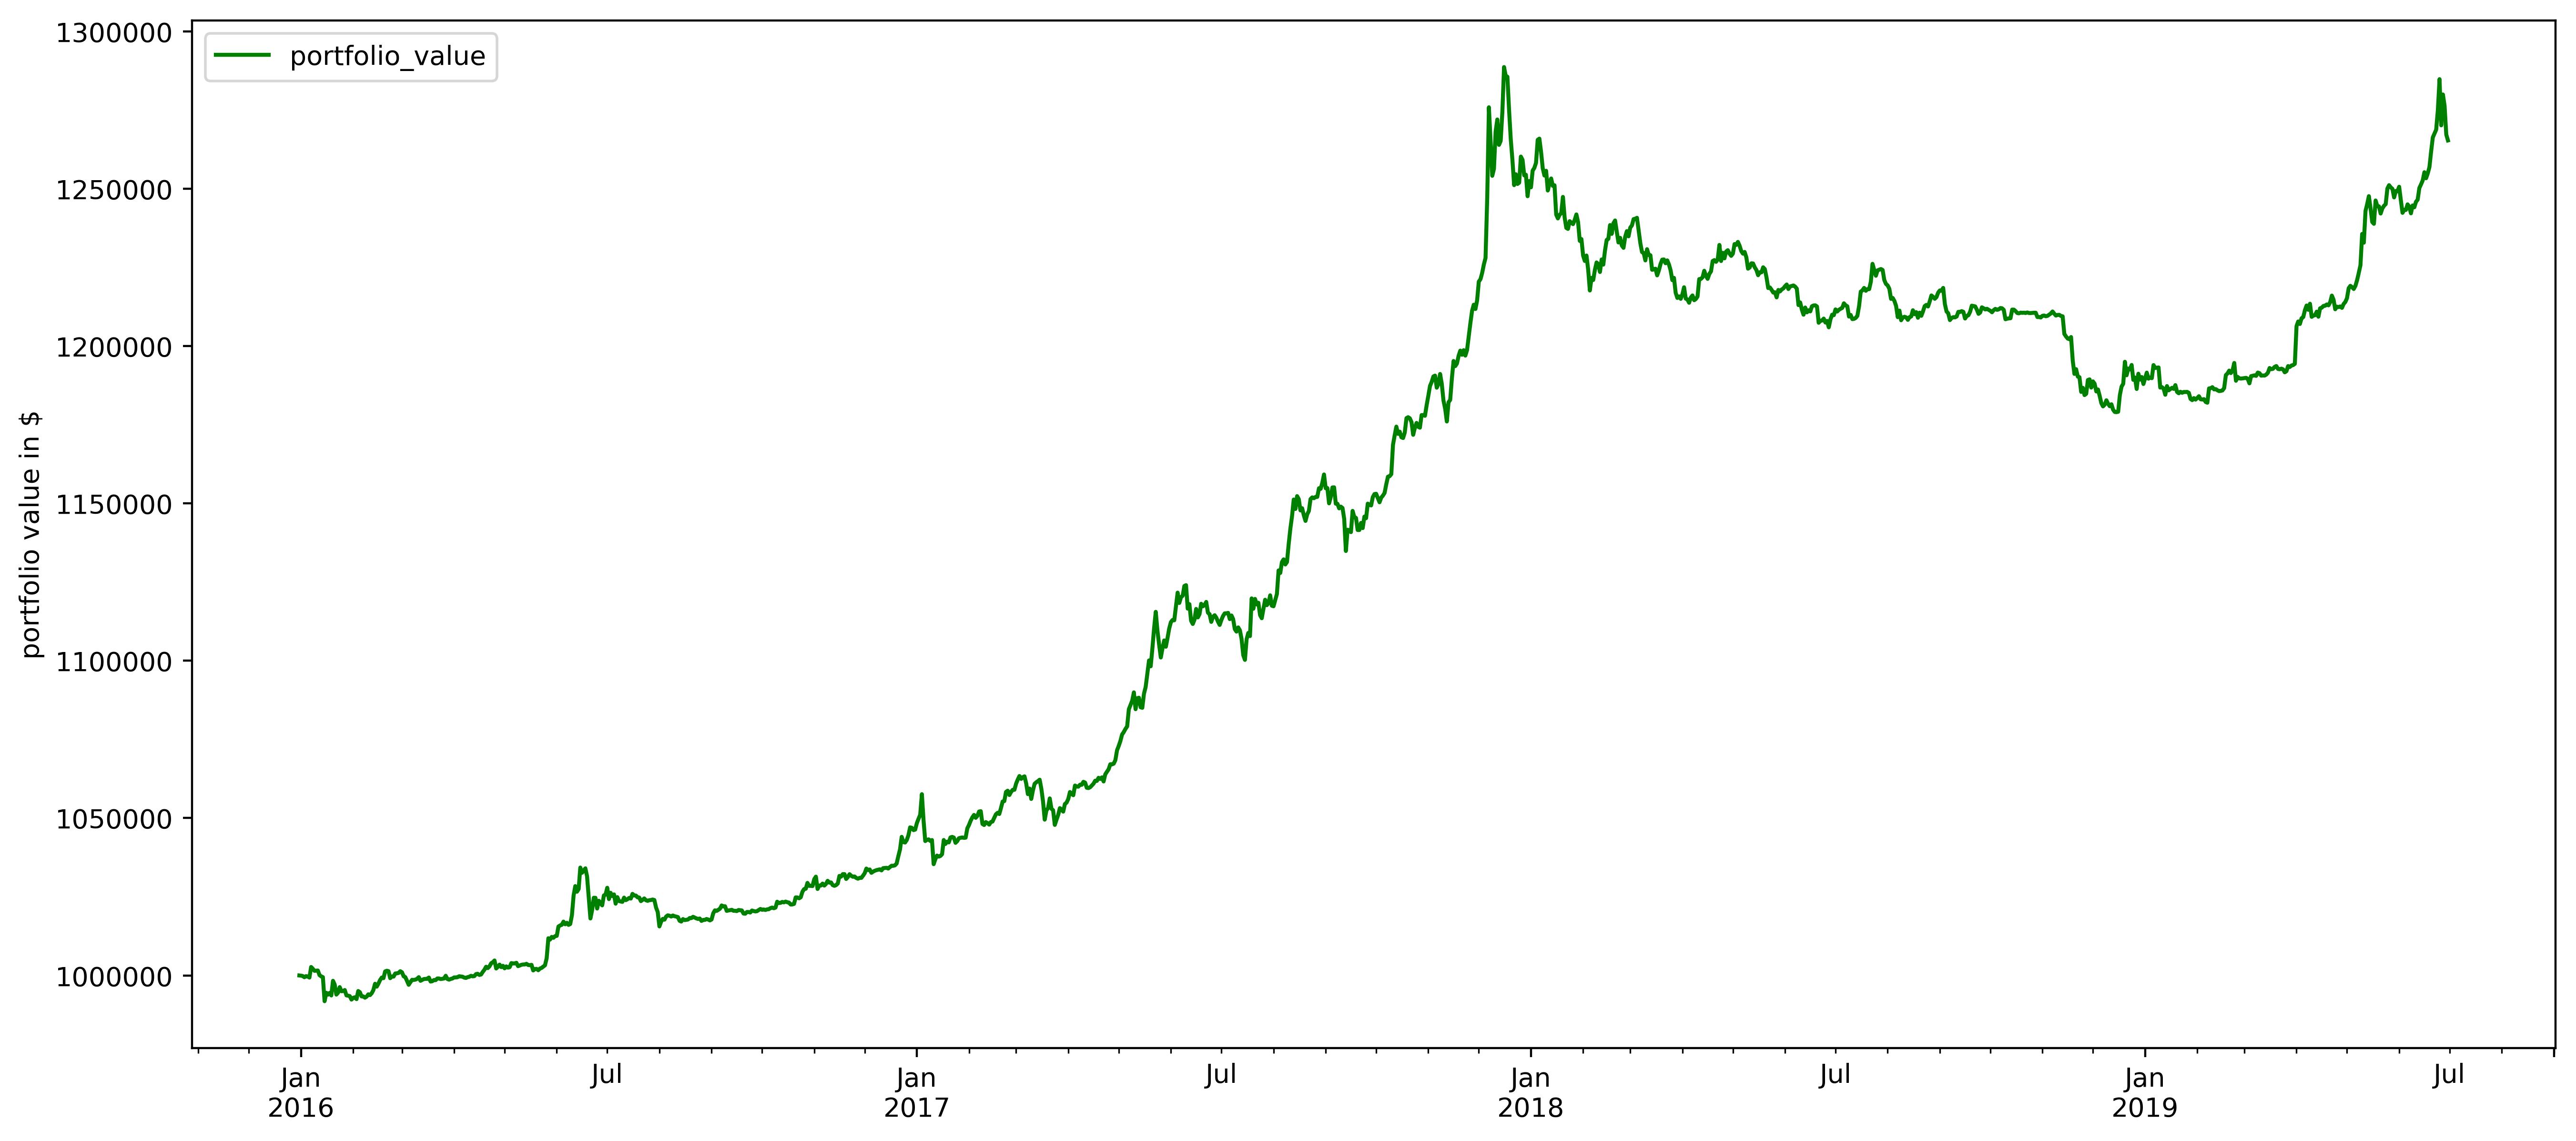

Final portfolio value (including cash): 1265304.52$


In [60]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.portfolio_value.plot(color='g')
ax.set_ylabel('portfolio value in $')
ax.tick_params(axais = 'x', direction = 'out')

plt.legend()
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

In [61]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

,Equity(1 [BTC]),cash
2016-01-01,50382.745728,949556.777344
2016-01-02,50278.806641,949556.777344
2016-01-03,49881.274414,949556.777344
2016-01-04,50238.556396,949556.777344
2016-01-05,50107.359009,949556.777344


In [224]:
# Поправляем названия столбцов

weights_df.columns = ['ETH', 'BTC', 'ICX', 'Cash']

In [225]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'] + weights_df['ICX'])    
norm_weights_df['ETH'] = weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'] + weights_df['ICX'])
norm_weights_df['ICX'] = weights_df['ICX']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'] + weights_df['ICX'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'] + weights_df['ICX'])

In [226]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [227]:
norm_weights_df.head()

,ETH,BTC,ICX,Cash
2015-08-11,0.0,0.788686,0.0,0.211314
2015-08-12,0.0,0.787240,0.0,0.212760
2015-08-13,0.0,0.788250,0.0,0.211750
2015-08-14,0.0,0.785624,0.0,0.214376
2015-08-15,0.0,0.783645,0.0,0.216355


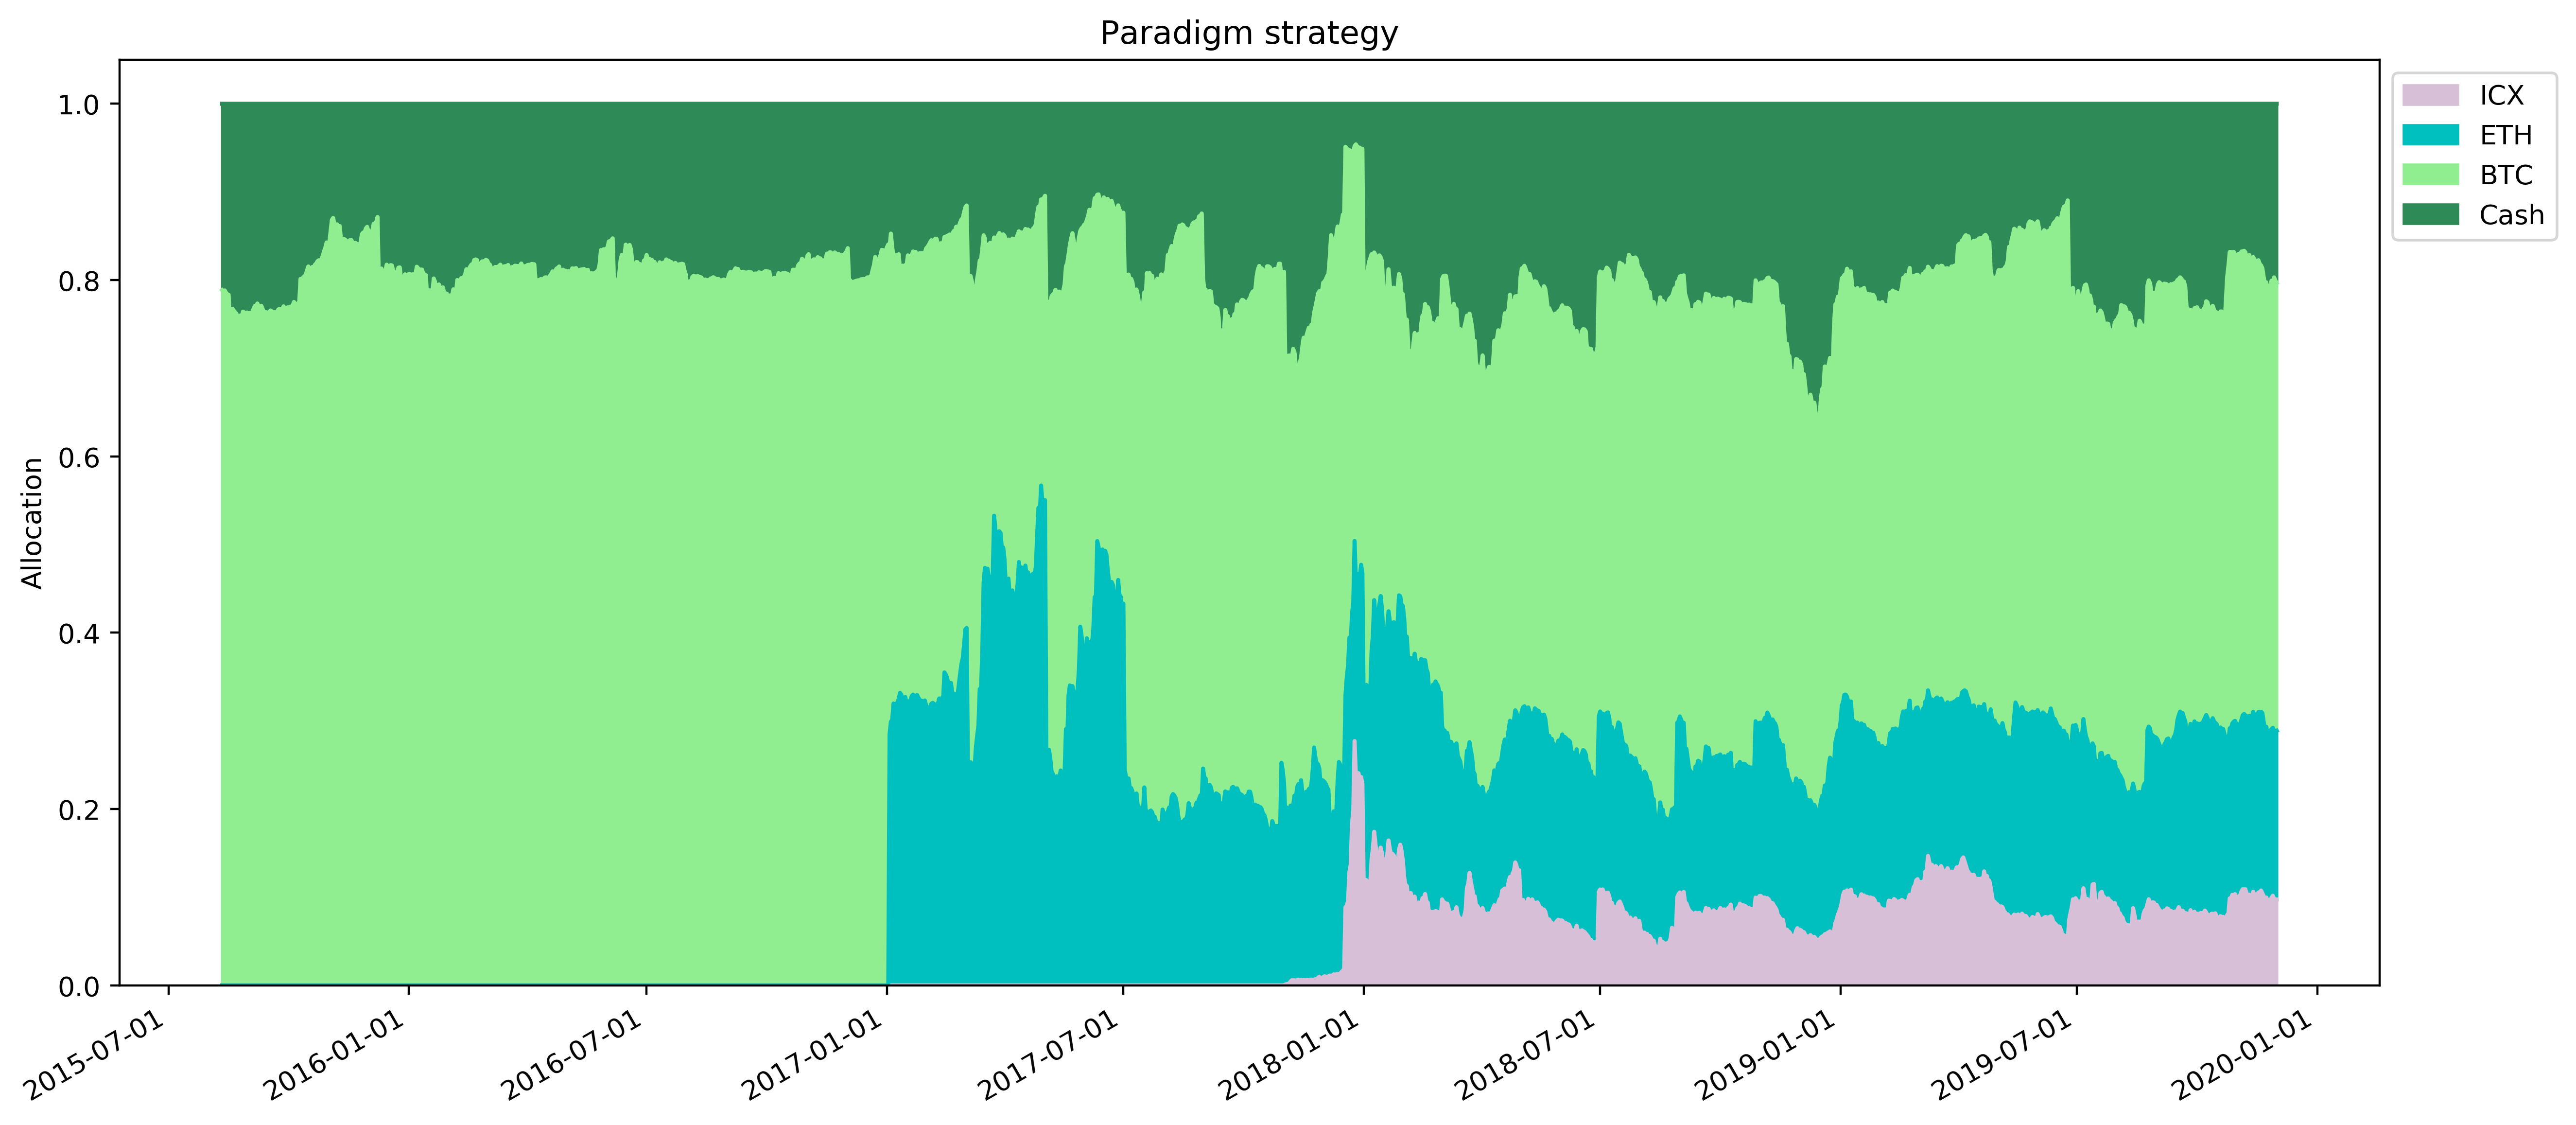

In [228]:
norm_weights_df = norm_weights_df[['ICX', 'ETH', 'BTC', 'Cash']]
# plot the results
col = ['thistle', 'c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()